<a href="https://colab.research.google.com/github/anxious-aurelius/afjal_big_data/blob/main/Afjal_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import matplotlib.pyplot as plt


In [ ]:
DATA_DIR = Path("/content")
f_orders = DATA_DIR / "olist_orders_dataset.csv"
f_items = DATA_DIR / "olist_order_items_dataset.csv"
f_payments = DATA_DIR / "olist_order_payments_dataset.csv"
f_reviews = DATA_DIR / "olist_order_reviews_dataset.csv"
f_custom = DATA_DIR / "olist_customers_dataset.csv"
f_products = DATA_DIR / "olist_products_dataset.csv"
f_pcat = DATA_DIR / "product_category_name_translation.csv"

parse_dates = ["order_purchase_timestamp",
               "order_approved_at",
               "order_delivered_carrier_date",
               "order_delivered_customer_date",
               "order_estimated_delivery_date"]

orders = pd.read_csv(f_orders, parse_dates=parse_dates)
items = pd.read_csv(f_items)
payments = pd.read_csv(f_payments)
reviews = pd.read_csv(f_reviews, parse_dates=["review_creation_date", "review_answer_timestamp"])
customers = pd.read_csv(f_custom)
products = pd.read_csv(f_products)
pcat = pd.read_csv(f_pcat)

# Memory-friendly categories
for col in ['order_id','customer_id','customer_unique_id','product_id','seller_id',
            'payment_type','customer_city','customer_state','product_category_name',
            'product_category_name_english','order_status']:
    for df_ in [orders, items, payments, reviews, customers, products]:
        if col in df_.columns:
            try:
                df_[col] = df_[col].astype('category')
            except Exception:
                pass

print(f"✓ Data loaded: {orders.shape[0]:,} orders")

✓ Data loaded: 99,441 orders


In [ ]:
# Filter only delivered orders
orders_delivered = orders[orders['order_status'] == 'delivered'].copy()

# Drop missing delivery or estimated dates
orders_delivered.dropna(
    subset=['order_delivered_customer_date', 'order_estimated_delivery_date'],
    inplace=True
)

# Optional: ensure chronological consistency
orders_delivered = orders_delivered[
    orders_delivered['order_delivered_customer_date'] >= orders_delivered['order_purchase_timestamp']
]


In [ ]:
# 1️⃣ Order status distribution BEFORE filtering
status_counts_before = orders['order_status'].value_counts()
status_percent_before = (
    orders['order_status'].value_counts(normalize=True).mul(100).round(2)
)

print("📦 Order Status Distribution (Before Filtering):")
print(pd.DataFrame({
    'Count': status_counts_before,
    'Percentage': status_percent_before
}))

# 2️⃣ Apply filtering
orders_delivered = orders[orders['order_status'] == 'delivered'].copy()
orders_delivered.dropna(
    subset=['order_delivered_customer_date', 'order_estimated_delivery_date'],
    inplace=True
)
orders_delivered = orders_delivered[
    orders_delivered['order_delivered_customer_date'] >=
    orders_delivered['order_purchase_timestamp']
]

# 3️⃣ Compare dataset sizes
print("\n🧾 Dataset Size Comparison:")
print(f"Before filtering: {orders.shape[0]:,} rows")
print(f"After filtering:  {orders_delivered.shape[0]:,} rows")

# 4️⃣ Order status distribution AFTER filtering
status_counts_after = orders_delivered['order_status'].value_counts()
status_percent_after = (
    orders_delivered['order_status'].value_counts(normalize=True).mul(100).round(2)
)

print("\n✅ Order Status Distribution (After Filtering):")
print(pd.DataFrame({
    'Count': status_counts_after,
    'Percentage': status_percent_after
}))


📦 Order Status Distribution (Before Filtering):
              Count  Percentage
order_status                   
delivered     96478       97.02
shipped        1107        1.11
canceled        625        0.63
unavailable     609        0.61
invoiced        314        0.32
processing      301        0.30
created           5        0.01
approved          2        0.00

🧾 Dataset Size Comparison:
Before filtering: 99,441 rows
After filtering:  96,470 rows

✅ Order Status Distribution (After Filtering):
              Count  Percentage
order_status                   
delivered     96470       100.0
approved          0         0.0
canceled          0         0.0
created           0         0.0
invoiced          0         0.0
processing        0         0.0
shipped           0         0.0
unavailable       0         0.0


96% of orders were successfully delivered; non-delivered records were excluded to ensure analytical consistency.

In [ ]:
# 1️⃣ Drop rows where review_score is missing
reviews_clean = reviews.dropna(subset=['review_score']).copy()

# 2️⃣ Sort by order_id and timestamp so the latest review is first
reviews_clean.sort_values(
    by=['order_id', 'review_answer_timestamp'],
    ascending=[True, False],
    inplace=True
)

# 3️⃣ Keep the latest review per order
reviews_clean = reviews_clean.drop_duplicates(subset='order_id', keep='first')

In [ ]:
# Before vs After shape comparison
print("🧾 Dataset Size Comparison:")
print(f"Before cleaning: {reviews.shape[0]:,} rows")
print(f"After cleaning:  {reviews_clean.shape[0]:,} rows")

# Check null values removed
print("\n❌ Missing review scores (before vs after):")
print(f"Before: {reviews['review_score'].isna().sum()}")
print(f"After:  {reviews_clean['review_score'].isna().sum()}")

# Check duplicate order_ids were removed
duplicate_before = reviews['order_id'].duplicated().sum()
duplicate_after = reviews_clean['order_id'].duplicated().sum()

print("\n🔁 Duplicate order_id entries (before vs after):")
print(f"Before: {duplicate_before}")
print(f"After:  {duplicate_after}")

# Optional: confirm the date order works
reviews_clean[['order_id','review_creation_date','review_answer_timestamp']].head()

🧾 Dataset Size Comparison:
Before cleaning: 99,224 rows
After cleaning:  98,673 rows

❌ Missing review scores (before vs after):
Before: 0
After:  0

🔁 Duplicate order_id entries (before vs after):
Before: 551
After:  0


,order_id,review_creation_date,review_answer_timestamp
51963,00010242fe8c5a6d1ba2dd792cb16214,2017-09-21,2017-09-22 10:57:03
27823,00018f77f2f0320c557190d7a144bdd3,2017-05-13,2017-05-15 11:34:13
4218,000229ec398224ef6ca0657da4fc703e,2018-01-23,2018-01-23 16:06:31
38844,00024acbcdf0a6daa1e931b038114c75,2018-08-15,2018-08-15 16:39:01
55676,00042b26cf59d7ce69dfabb4e55b4fd9,2017-03-02,2017-03-03 10:54:59


In [ ]:
# Inner join ensures we keep only orders that have a corresponding review
orders_reviewed = pd.merge(
    orders_delivered,
    reviews_clean[['order_id', 'review_score', 'review_creation_date', 'review_answer_timestamp']],
    on='order_id',
    how='inner'
)

In [ ]:
# Dataset size before and after merging
print("🧾 Dataset Size Comparison:")
print(f"Delivered orders: {orders_delivered.shape[0]:,}")
print(f"Cleaned reviews:  {reviews_clean.shape[0]:,}")
print(f"Merged dataset:   {orders_reviewed.shape[0]:,}")

# Sanity check: should have no nulls in key columns
print("\n🔍 Missing Values in Key Columns:")
print(orders_reviewed[['order_id', 'order_status', 'review_score']].isna().sum())

# Quick check of review score distribution
print("\n⭐ Review Score Distribution:")
print(orders_reviewed['review_score'].value_counts(normalize=True).mul(100).round(2))

🧾 Dataset Size Comparison:
Delivered orders: 96,470
Cleaned reviews:  98,673
Merged dataset:   95,824

🔍 Missing Values in Key Columns:
order_id        0
order_status    0
review_score    0
dtype: int64

⭐ Review Score Distribution:
review_score
5    59.22
4    19.71
1     9.76
3     8.26
2     3.05
Name: proportion, dtype: float64


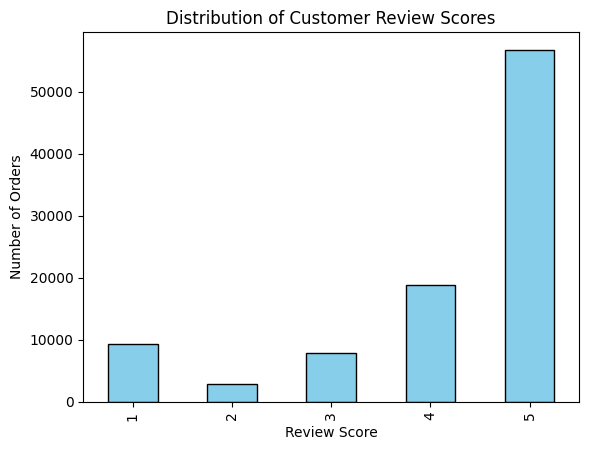

In [ ]:

orders_reviewed['review_score'].value_counts().sort_index().plot(
    kind='bar', color='skyblue', edgecolor='black'
)
plt.title("Distribution of Customer Review Scores")
plt.xlabel("Review Score")
plt.ylabel("Number of Orders")
plt.show()

In [ ]:
# print("🧾 Dataset Overview:")
# print(orders_reviewed.info())
# print("\nQuick Summary Stats:")
# display(orders_reviewed.describe(include='all'))


In [ ]:
# # Count total nulls per column
# print("\n🔍 Missing Values by Column:")
# print(orders_reviewed.isna().sum().sort_values(ascending=False).head(10))

# # Sanity check: should have zero nulls in key columns
# key_cols = ['order_id', 'order_status', 'review_score',
#             'order_purchase_timestamp', 'order_delivered_customer_date']
# print("\nKey Columns Null Check:")
# print(orders_reviewed[key_cols].isna().sum())

In [ ]:
print(f"✅ orders_reviewed shape: {orders_reviewed.shape}")
print(f"🔁 Duplicates: {orders_reviewed['order_id'].duplicated().sum()}")
print(f"⚠️ Missing values: {orders_reviewed.isna().sum().sum()}")

✅ orders_reviewed shape: (95824, 11)
🔁 Duplicates: 0
⚠️ Missing values: 15


In [ ]:


# Check datatypes of all datetime-related columns
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

print("🧭 Checking datetime columns in 'orders' table:\n")
for col in date_cols:
    dtype = orders[col].dtype
    print(f"{col:<35}: {dtype}")

🧭 Checking datetime columns in 'orders' table:

order_purchase_timestamp           : datetime64[ns]
order_approved_at                  : datetime64[ns]
order_delivered_carrier_date       : datetime64[ns]
order_delivered_customer_date      : datetime64[ns]
order_estimated_delivery_date      : datetime64[ns]


In [ ]:
for col in date_cols:
    invalid = orders[~orders[col].apply(lambda x: pd.api.types.is_datetime64_any_dtype(type(x)))][col]
    if not invalid.empty:
        print(f"⚠️ Non-datetime entries found in {col}:")
        print(invalid.head())
    else:
        print(f"✅ {col} — all entries are datetime objects")

⚠️ Non-datetime entries found in order_purchase_timestamp:
0   2017-10-02 10:56:33
1   2018-07-24 20:41:37
2   2018-08-08 08:38:49
3   2017-11-18 19:28:06
4   2018-02-13 21:18:39
Name: order_purchase_timestamp, dtype: datetime64[ns]
⚠️ Non-datetime entries found in order_approved_at:
0   2017-10-02 11:07:15
1   2018-07-26 03:24:27
2   2018-08-08 08:55:23
3   2017-11-18 19:45:59
4   2018-02-13 22:20:29
Name: order_approved_at, dtype: datetime64[ns]
⚠️ Non-datetime entries found in order_delivered_carrier_date:
0   2017-10-04 19:55:00
1   2018-07-26 14:31:00
2   2018-08-08 13:50:00
3   2017-11-22 13:39:59
4   2018-02-14 19:46:34
Name: order_delivered_carrier_date, dtype: datetime64[ns]
⚠️ Non-datetime entries found in order_delivered_customer_date:
0   2017-10-10 21:25:13
1   2018-08-07 15:27:45
2   2018-08-17 18:06:29
3   2017-12-02 00:28:42
4   2018-02-16 18:17:02
Name: order_delivered_customer_date, dtype: datetime64[ns]
⚠️ Non-datetime entries found in order_estimated_delivery_date:


In [ ]:
for col in date_cols:
    print(f"\n🕒 Sample unique values from {col}:")
    print(orders[col].dropna().sort_values().head(3))
    print(orders[col].dropna().sort_values().tail(3))


🕒 Sample unique values from order_purchase_timestamp:
4541    2016-09-04 21:15:19
4396    2016-09-05 00:15:34
10071   2016-09-13 15:24:19
Name: order_purchase_timestamp, dtype: datetime64[ns]
31891   2018-10-03 18:55:29
68373   2018-10-16 20:16:02
60938   2018-10-17 17:30:18
Name: order_purchase_timestamp, dtype: datetime64[ns]

🕒 Sample unique values from order_approved_at:
30710   2016-09-15 12:16:38
64058   2016-10-04 09:43:32
92636   2016-10-04 10:18:57
Name: order_approved_at, dtype: datetime64[ns]
69678   2018-08-29 15:05:22
88097   2018-08-29 15:10:26
62360   2018-09-03 17:40:06
Name: order_approved_at, dtype: datetime64[ns]

🕒 Sample unique values from order_delivered_carrier_date:
6747    2016-10-08 10:34:01
59102   2016-10-08 13:46:32
1384    2016-10-08 14:46:49
Name: order_delivered_carrier_date, dtype: datetime64[ns]
21938   2018-09-03 12:56:00
62360   2018-09-04 15:25:00
96277   2018-09-11 19:48:28
Name: order_delivered_carrier_date, dtype: datetime64[ns]

🕒 Sample unique

In [ ]:
orders[col] = pd.to_datetime(orders[col], errors='coerce')